In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
print(engine.table_names())

['measurement', 'station']


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [ ]:
# Different way of getting the table's column names to display
# inspector = inspect(engine)
# inspector.get_table_names()

In [ ]:
# columns = inspector.get_columns('measurement')
# for c in columns:
#     print(c['name'], c["type"])

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)
measurement_df = pd.read_sql("select * from measurement", engine)
measurement_df.head(10)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [79]:
station_df = pd.read_sql("select * from station", engine)
station_df.head(10)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Climate Analysis

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# First find the most recent date available in the "Measurement" data table
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point for date in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [76]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
last_twelve_months = session.query(*sel).\
        filter(Measurement.date > query_date).\
        order_by(Measurement.date).all()
# last_twelve_months

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_twelve_months_df = pd.DataFrame(last_twelve_months, columns = ["Date", "Precipitation"])

In [16]:
#Set index to date column
last_twelve_months_df.set_index("Date", inplace=True)

In [ ]:
# Sort the dataframe by date (see above - used order_by)

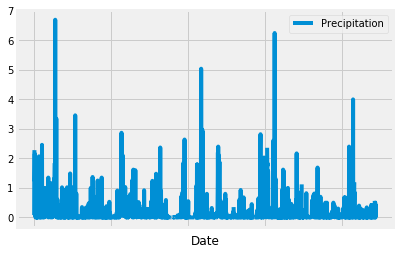

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
last_twelve_months_df.plot()
# plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_twelve_months_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(func.count(Station.station)).all()
number_stations

[(9)]

In [20]:
combined_data = session.query(Measurement, Station).filter(Measurement.station == Station.station).limit(10).all()

In [24]:
# Check to see what table is printing
# for record in combined_data:
#     (measurement, station) = record
#     print(measurement.station)
#     print(station.station)

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
sel = [func.count(Measurement.station), Measurement.station]

# List the stations and the counts in descending order.
active_stations = session.query(*sel).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
active_stations

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, func.max(Measurement.tobs)]
max_temp = session.query(*sel).all()
max_temp

[('USC00519397', 87.0)]

In [23]:
sel = [Measurement.station, func.min(Measurement.tobs)]
min_temp = session.query(*sel).all()
min_temp

[('USC00511918', 53.0)]

In [24]:
sel = [Measurement.station, func.avg(Measurement.tobs)]
avg_temp = session.query(*sel).all()
avg_temp

[('USC00519397', 73.09795396419437)]

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
highest_tobs = session.query(*sel).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date > query_date).all()
# highest_tobs

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [51]:
# Put the data into a dataframe
highest_tobs_df = pd.DataFrame(highest_tobs, columns = ["Date", "Temperature"])

In [52]:
# Set index
highest_tobs_df.set_index("Date", inplace=True)

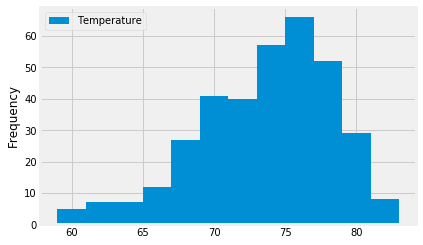

In [54]:
# Create the histogram
highest_tobs_df.plot.hist(bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

# TMIN, MAX, TAVG = calc_temps('2012-02-28', '2012-03-05')


[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
 
print(calc_temps('2017-07-01', '2017-07-08'))

[(71.0, 78.04347826086956, 87.0)]


In [83]:
# Define TMIN, TAVG, TMAX
TMIN, TAVG, TMAX = calc_temps('2017-07-01', '2017-07-08')[0]
TMIN, TAVG, TMAX

(71.0, 78.04347826086956, 87.0)

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
last_twelve_months_df.plot()
# plt.tight_layout()
plt.show()

In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
annual_rainfall = session.query(*sel).\
filter(Measurement.station == Station.station).\
filter(Measurement.date > query_date).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()
annual_rainfall

[('USC00516128',
  147.11000000000004,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  68.24000000000002,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  48.36000000000003,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  37.99,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  33.19,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  16.089999999999986,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [69]:
annual_rainfall_df = pd.DataFrame(annual_rainfall, columns = ["Station Number", "Total Annual Precipitation", "Station Name",
                                                             "Latitude", "Longitude", "Elevation"])
annual_rainfall_df.head(9)

,Station Number,Total Annual Precipitation,Station Name,Latitude,Longitude,Elevation
0,USC00516128,147.11,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,68.24,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,48.36,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,37.99,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,33.19,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
